# Optics of the *M. amalphitanum* eye
- View ommatidia measurements from AM and team 
- Calculate optical parameters from physical measurements
- Perform clustering on these physical features, compare with lamina circuit clustering

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import math
import os.path
import json
from typing import Tuple
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import mannwhitneyu

from cx_analysis.utils import index_by_om, yymmdd_today
from cx_analysis.dataframe_tools import assemble_cxvectors
from cx_analysis.vis.fig_tools import linear_cmap, subtype_cm
from cx_analysis.vis.hex_lattice import hexplot_TEST, hexplot, om_to_hex

In [3]:
plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle')
### SAVE FIGS? ###
save_figs=False
fig_path = os.path.expanduser(f'~/figures/')
##################
# if save_figs:
#     fig.savefig(fig_path + fname + '.svg')
#     fig.savefig(fig_path + fname + '.png')

In [4]:
tp = '210809'
data_path = f'Data/'  
replace_with_left = True

In [5]:
optics_df = pd.read_excel(data_path + '1911_anastasia_om_measurements.xlsx', index_col=0)
optics_df = optics_df.iloc[1:-2] # remove last two lines of excel file

# Add pre-computed rhabdom lengths (from rhabdomere_lengths.ipynb)
rh_len = pd.read_pickle(data_path + '201123_rh_len_df.pickle')
for i, v in rh_len.iterrows():
    optics_df.loc[i, 'rhabdom_len'] = float(v)

### Replace manual curvature measurements with JP's ###
optics_df = optics_df.drop(['outer curvature', 'inner curvature'], axis=1)
with open(os.path.expanduser(data_path + '210723_jp_optics_measurements.json')) as fh:
    jp_data = json.load(fh)

right_om_labels = {'A0': 73, 'B0': 72, 
                  'A1': 71, 'B1': 70, 'C1': 69, 
                  'A2': 68, 'B2': 67, 'C2': 66, 'D2': 65, 
                  'A3': 64, 'B3': 63, 'C3': 61, 'D3': 62, 
                  'A4': 60, 'B4': 57, 'E4': 59,  
                  'A5': 56, 'B5': 55, 'C5': 54, 'D5': 53,
                  'B6': 52, 'E6': 51}

r_in = []
r_out = []
lens_centers_in = {}
lens_centers_out = {}
for om in optics_df.index:
    if om in right_om_labels.keys():
        r_in.append(jp_data['radii_in'][str(right_om_labels[om])])
        r_out.append(jp_data['radii_out'][str(right_om_labels[om])])
        lens_centers_in[om] = np.array(jp_data['centers_in'][str(right_om_labels[om])])
        lens_centers_out[om] = np.array(jp_data['centers_out'][str(right_om_labels[om])])
                                    
    else:
        r_in.append(np.nan)
        r_out.append(np.nan)
# Convert radii and center coordinates to microns
optics_df.loc[:, 'radius_in'] = np.array(r_in) / 1000.0
optics_df.loc[:, 'radius_out'] = np.array(r_out) / 1000.0 
lens_centers_in = pd.Series(lens_centers_in, dtype='object', name='lens_centers_in') / 1000.0
lens_centers_out = pd.Series(lens_centers_out, dtype='object', name='lens_centers_out') / 1000.0

In [6]:
def dist_from_centers(ind):
    """distance between inner and outer lens poles"""
    in_coord = np.array(jp_data['centers_in'][ind])
    out_coord = np.array(jp_data['centers_out'][ind])
    dist = np.linalg.norm(in_coord - out_coord)
    display(dist)
    return dist  # nanometers

In [7]:
if replace_with_left:
    # replace damaged lens with values from corresponding left ommatidia 
    left_right_error = dict()
    left_om_labels = {'A0': 12, 'B0': 19, 
                 'A1': 11, 'B1': 21, 'C1': 26,
                 'A2': 7, 'B2': 17, 'C2': 24, 'D2': 28, 
                 'A3': 4, 'B3': 15, 'C3': 23, 'D3': 29, 
                 'A4': 2, 'B4': 10, 'C4': 18, 'D4': 25, 'E4': 27, 
                 'A5': 1, 'B5': 6, 'C5': 14, 'D5': 20, 'E5': 22, 
                 'B6': 3, 'C6': 9, 'D6': 13, 'E6': 16, 
                 'D7': 5, 'E7': 8}
    for om in optics_df.index:
        left_i = str(left_om_labels[om])
        if om not in right_om_labels.keys():
            # use measurement from left eye
            optics_df.loc[om, 'radius_in'] = jp_data['radii_in'][left_i] / 1000.0 * -1.0
            optics_df.loc[om, 'radius_out'] = jp_data['radii_out'][left_i] / 1000.0
            
            # calculate thickness
            optics_df.loc[om, 'lens_thickness'] = dist_from_centers(left_i) / 1000.0
            
        else:
            # use left/right average if measurement is available on both sides
            right_i = str(right_om_labels[om])
            optics_df.loc[om, 'radius_in'] = (jp_data['radii_in'][left_i] + jp_data['radii_in'][right_i])/ 2.0 / 1000.0 * -1.0
            optics_df.loc[om, 'radius_out'] = (jp_data['radii_out'][left_i] + jp_data['radii_out'][right_i])/ 2.0 / 1000.0
            optics_df.loc[om, 'lens_thickness'] = (dist_from_centers(left_i) + dist_from_centers(right_i)) / 2.0 / 1000.0

else:
    for om in optics_df.index:
        if om in right_om_labels.keys():
            optics_df.loc[om, 'lens_thickness'] = dist_from_centers(str(right_om_labels[om])) / 1000.0
        else:
            optics_df.loc[om, 'lens_thickness'] = np.nan
            

display(optics_df.describe().round(2))

1822.9042764563499

3413.9278094062556

741.7603815960381

4518.354059793307

4656.233527579068

3989.3725021331934

1799.1889657899837

1438.8722968829024

3455.3372433918094

1448.7869985489697

1605.7549860574086

2662.6818372227567

4499.827077715809

3086.159421792861

4055.7854063324075

785.6286651423189

3893.8260394772824

3876.129644800333

3448.009658152756

1135.193398281378

5044.769955459503

2343.275977294414

5049.986817104545

2322.7680077602095

4830.460263931288

1981.480518473576

1828.1842821292887

2213.400336666189

2327.81250444588

3703.6973343700242

3323.4744379610925

2995.2909724621295

4363.157469230485

2521.542961907916

4952.91147674006

3501.3376699865335

4215.260629983529

2230.00768174561

4609.659229689438

1842.4710867127715

1898.9079908204824

3849.5904330960448

3092.8626815135567

4036.481999521469

5039.894869388294

4315.038381014489

4569.274404886179

3352.7418086125485

4814.511140935859

4111.7930009670445

5515.746172860593

,lense thickness,cone length (from the tip),cone width (under the lense tip),D rhabdom dist.,D rhabdom prox.,Mean Microv. Ang. Turn,rhabdom_len,radius_in,radius_out,lens_thickness
count,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00
mean,3.01,4.07,6.04,2.49,1.89,26.79,14.26,-2.55,3.48,3.15
std,0.59,0.93,0.97,0.41,0.45,9.32,1.56,0.75,0.89,1.09
min,1.89,2.37,4.14,1.78,1.17,7.81,11.09,-3.85,1.34,0.79
25%,2.65,3.34,5.52,2.14,1.45,18.09,13.31,-2.99,2.61,2.08
50%,3.02,4.34,6.45,2.52,2.04,26.41,13.98,-2.65,3.65,3.51
75%,3.48,4.73,6.73,2.85,2.27,33.77,14.88,-2.38,4.20,3.86
max,4.19,6.10,7.20,3.10,2.45,42.78,18.25,-1.12,4.47,4.81


## Lens calculations
### Measurements (all $\mu{m}$)
- Lens: Outer radius of curvature, $r_1$
- Lens: Inner radius of curvature, $r_2$
- Lens: thickness, $t$
- Lens: diameter, $D$
- Rhabdom: distal diameter, $D_{Rh}$
- Rhabdom: length, $l_{Rh}$
- Measurements also taken for the length and distal width of the crystalline cone, and the proximal diameter of the rhabdom (not used for the following calculations) 

### Calculations
- We used the refractive indices of the honey bee lens ($n_l$) and crystalline cone ($n_c$), from Valera & Wiitanen (1970)
- Equivalent power of a thick lens ($\mu{m}^{-1}$) $P_{eq}$, calculated using the thick lens formula (Fundamentals of Optics, Jenkins & White, p.84, 2001): 
$$P_{eq} = P_1 + P_2 - \frac{t}{n_l} P_1 P_2$$
    - $P_1 = \frac{n_l - 1.0}{r_1}$, power from outer lens surface (air->lens)
    - $P_2 = \frac{n_c - n_l}{r_2}$, power from inner lens surface (lens->cone) 
- Focal length of the object ($\mu{m}$): $f = 1/P$
- Focal length of the image ($\mu{m}$): $f' = {n_c}/P$

- Outer and inner principle planes ($\mu{m}$): 
$$e_{out} = (t\frac{n_0}{n_l})(\frac{P_2}{P_{eq}})$$
$$e_{in} = -(t\frac{n_c}{n_l})(\frac{P_1}{P_{eq}})$$


- Back focal distance ($\mu{m}$): BFD = $BFD = f'(1 - \frac{(n_l-n_c)t}{n_lr_1})$
- F-number: $F = f/D$
- The acceptance angle of an ommatidium, $\Delta\rho$, is proscribed by diffraction effects at the lens,  $\Delta\rho_l$, and the geometry of the distal rhabdom tip and the lens, $\Delta\rho_{Rh}$ (Snyder, 1979):
$$\Delta\rho = \sqrt{{\Delta\rho_l}^2 + {\Delta\rho_{Rh}}^2}$$
    - $\Delta\rho_l = \lambda/D$, where we set $\lambda$ = 0.5 $\mu{m}$ (green monochromatic light)
    - $\Delta\rho_{Rh} = D_{Rh}/f$
- Optical sensitivity to an extended broadband-spectrum source, $S$ ($\mu{m}^2{sr}$), approximated by:  
$$S = (\frac{\pi}{4})^2 D^2 {\Delta\rho}^2 \frac{k{l}_{Rh}}{2.3 + k{l}_{Rh}}$$
    - See [Fredriksen and Warrant, 2008](https://dx.doi.org/10.1098%2Frsbl.2008.0467); [Kirschfeld, 1974](https://doi.org/10.1515/znc-1974-9-1023)
    - k is the peak absorbtion (length) coefficient of the visual pigment, taken as 0.0067 $\mu{m}^-1$ (Warrant et al., 2004)
    - Notes: facet area is $\frac{\pi{D}^2}{4}$, the fraction of incident light absorbed is $\frac{k{l}_{Rh}}{2.3 + k{l}_{Rh}}$



In [8]:
# refraction indices
n0 = 1.0    # air
nl = 1.452  # lens
nc = 1.348  # crys cone

def power_terms(r_outer: float, r_inner: float, thin_approx: bool=False, t: float=0.0) -> float:
    
    # Check sign convention 
    #assert(r_outer >= 0.0)  # Outer is positive
    #assert(r_inner <= 0.0)  # Inner is negative

    p1 = (nl - 1.0)/r_outer # interface air->lens 
    p2 = (nc - nl)/r_inner # interface lens->cone
    if thin_approx:
        return p1, p2
    else:
        if t == 0.0:
            raise ValueError("t must be passed if thin_approx=False (the default option)")
        else:
            p3 = (t/nl) * p1 * p2
            return p1, p2, p3

        
def focal_length(r_outer: float, r_inner: float, thin_approx: bool=False, t: float=0.0) -> float:
    
    if thin_approx:
        p1, p2 = power_terms(r_outer, r_inner)
        return 1.0/(p1 + p2)
    else:
        p1, p2, p3 = power_terms(r_outer, r_inner, t=t)
        print(p2)
        return 1.0/(p1 + p2 - p3)


def principle_plane_dist(r_outer: float, r_inner: float, t: float) -> Tuple:
    # Requires t, lens thickness
    p1, p2, p3 = power_terms(r_outer, r_inner, t=t)
    equiv_power = p1 + p2 - p3
    e_front = (n0 * t / nc) * (p2/equiv_power)
    e_back = -1.0 * (nl * t / nc) * (p1/equiv_power)
    
    return e_front, e_back

        
def back_focal_distance(im_focal_len: float, r_outer: float, lens_thickness: float) -> float:
    
    # Check sign convention 
    #assert(r_outer > 0.0)  # Outer RoC is positive by convention
    
    #principle = ((nl - nc) * lens_thickness)/(nc * r_outer)
    principle = ((nl - nc) * lens_thickness)/(nc * r_outer)
    bfd = im_focal_len * (1.0 - principle)
    
    return bfd


def acceptance_angle(D, Dr, f): # lens diameter, distal rhabdom diameter, focal length
    # Acceptance angle
    rho_l = 0.5/D # angular sens. due to diffraction at the lens, 500nm light
    rho_rh = Dr/f # angular sens. due to geometry of rhabdom tip
    # 'simple' acceptance angle formula 
    rho = (rho_l ** 2.0 + rho_rh ** 2.0) ** (0.5)
    
    return rho_l, rho_rh, rho # radians

In [9]:
#optics_df.to_csv(os.path.join(fig_path, 'optics_df_leftreplaced.csv'))

In [10]:
r_out = optics_df['radius_out']
r_in = optics_df['radius_in']
#l_thick = optics_df['lense thickness']   # lense thickness is for AM's manual measurements
l_thick = optics_df['lens_thickness'] # lens_thickness uses distance computed from lens centers 
D = optics_df['lense diameter (stack)'].astype('float')
Dr = optics_df['D rhabdom dist.']
lr = optics_df['rhabdom_len']
# focal length
f = np.array([focal_length(r_outer=r1, r_inner=r2, t=t) for r1, r2, t in zip(r_out, r_in, l_thick)])
fi = f * 1.348
bfd = np.array([back_focal_distance(this_f, r_outer, t) for this_f, r_outer, t in zip(fi, r_out, l_thick)])  
e_front, e_back = np.array([principle_plane_dist(r1, r2, t) for r1, r2, t in zip(r_out, r_in, l_thick)]).T
# Acceptance angle
# will be converted rad->deg when added to optics_df
# rho = (rho_l ** (2.0) + rho_rh ** (2.0)) ** (0.5)
rho_l, rho_rh, rho = acceptance_angle(D, Dr, f)
# Optical sensitivity
k = 0.0067 # peak absorbtion coefficient (wrt rhabdom length) from Warrant et al., 2004
kl = k * lr
S = ((np.pi / 4.0)**2.0) * (D ** 2.0) * (rho ** 2.0) * (kl / (2.3 + kl))

optics_df['f'] = f.astype('float') 
optics_df['f-image'] = fi.astype('float') 
optics_df['P'] = (1.0/f).astype('float') 
optics_df['bfd'] = bfd.astype('float') 
optics_df['e_front'] = e_front.astype('float')
optics_df['e_back'] = e_back.astype('float')
optics_df['rho_l'] = np.degrees(rho_l.astype('float') )
optics_df['rho_rh'] = np.degrees(rho_rh.astype('float') )
optics_df['rho'] = np.degrees(rho.astype('float') )
optics_df['S'] = S.astype('float')  

display(optics_df[['rho_l', 'rho_rh', 'rho']])
display(optics_df.describe().round(2))
#optics_df.to_csv(f'~/Data/{tp}_lamina/{tp}_optics.csv' )

0.08131475965767372
0.04266374656309982
0.03091289147654999
0.02955168591232337
0.0674081896818935
0.0724381959398566
0.03983321989258162
0.04213516695512112
0.04375367069879707
0.03641982221325241
0.0930029388990847
0.03927447080524638
0.03932796544201886
0.037033286222332124
0.039620626447140664
0.03262525094294549
0.08622547751022441
0.057698632737635556
0.04111972656331405
0.03709395117730424
0.03905302652004765
0.038868852959739845
0.034800255759208545
0.06908506572851955
0.03382856045798397
0.027030445158127407
0.03239398432549323
0.036373953821297225
0.0276847525795506


,rho_l,rho_rh,rho
E7,4.138074,26.513166,26.834151
E6,4.103853,26.659250,26.973268
E5,3.092723,17.670754,17.939355
E4,3.546598,25.431026,25.677139
D7,4.479032,29.350541,29.690335
D6,3.960173,28.620504,28.893186
D5,3.508741,23.803365,24.060578
D4,3.568496,35.374750,35.554284
D3,3.958148,24.229367,24.550543
D2,3.906026,25.444439,25.742504


,lense thickness,cone length (from the tip),cone width (under the lense tip),D rhabdom dist.,D rhabdom prox.,Mean Microv. Ang. Turn,rhabdom_len,radius_in,radius_out,lens_thickness,f,f-image,P,bfd,e_front,e_back,rho_l,rho_rh,rho,S
count,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00
mean,3.01,4.07,6.04,2.49,1.89,26.79,14.26,-2.55,3.48,3.15,6.25,8.42,0.18,7.83,0.61,-2.76,3.81,24.14,24.45,0.26
std,0.59,0.93,0.97,0.41,0.45,9.32,1.56,0.75,0.89,1.09,1.62,2.19,0.07,1.99,0.21,1.01,0.49,6.40,6.38,0.12
min,1.89,2.37,4.14,1.78,1.17,7.81,11.09,-3.85,1.34,0.79,2.42,3.26,0.12,3.12,0.13,-4.46,3.09,16.17,16.46,0.13
25%,2.65,3.34,5.52,2.14,1.45,18.09,13.31,-2.99,2.61,2.08,4.82,6.49,0.13,6.08,0.43,-3.27,3.51,20.87,21.14,0.19
50%,3.02,4.34,6.45,2.52,2.04,26.41,13.98,-2.65,3.65,3.51,6.73,9.07,0.15,8.41,0.63,-3.07,3.75,23.27,23.64,0.23
75%,3.48,4.73,6.73,2.85,2.27,33.77,14.88,-2.38,4.20,3.86,7.61,10.26,0.21,9.59,0.79,-1.89,4.10,25.44,25.74,0.28
max,4.19,6.10,7.20,3.10,2.45,42.78,18.25,-1.12,4.47,4.81,8.08,10.89,0.41,10.05,0.87,-0.69,5.02,48.69,48.91,0.70


## Interommatidial distances

In [11]:
def hex_distance(o1: str, o2: str) -> float:
    c1 = np.array(om_to_hex(o1, scale_factor=1.0))
    c2 = np.array(om_to_hex(o2, scale_factor=1.0))
    
    return np.linalg.norm(c1-c2)

pairs = list(itertools.combinations(lens_centers_out.index, 2))

ret_dist = []
hex_dist = []
for o1, o2 in pairs:
    ret_dist.append(np.linalg.norm(lens_centers_out[o1] - lens_centers_out[o2]))
    hex_dist.append(hex_distance(o1, o2))

pair_dist = pd.DataFrame(data=np.transpose([ret_dist, hex_dist]), columns=['ret_dist', 'hex_dist'], index=pairs)
print((pair_dist['ret_dist'] / pair_dist['hex_dist']).describe())
print(pair_dist.loc[pair_dist['hex_dist'] <= 1.1, 'ret_dist'].describe())


count    231.000000
mean       8.504175
std        1.264842
min        5.354791
25%        7.805049
50%        8.493867
75%        9.109067
max       15.897470
dtype: float64
count    41.000000
mean      8.920935
std       2.106250
min       5.791004
25%       7.710840
50%       8.196163
75%       9.771404
max      15.897470
Name: ret_dist, dtype: float64


In [12]:

np.mean(np.degrees((optics_df['D rhabdom dist.']/optics_df['f'])))
# rho = sqrt((Drh/f)**2 + (lambda/Dlens)**2)
Drh = optics_df.loc[:, 'D rhabdom dist.']
f = optics_df.loc[:, 'f']

wavelen = 0.500
Dlens =  optics_df.loc[:, 'lense diameter (stack)'].astype('float')

rhorh_rhol_acceptance = pd.DataFrame(data={'Drh/f': np.degrees(Drh/f), 
                                           '0.5/Dlens': np.degrees(wavelen/Dlens), 
                                           'Acceptance (deg.)': np.degrees(((Drh/f)**2.0 + (wavelen/Dlens)**2.0) ** 0.5)})
display(rhorh_rhol_acceptance.describe())

,Drh/f,0.5/Dlens,Acceptance (deg.)
count,29.000000,29.000000,29.000000
mean,24.140788,3.807623,24.449423
std,6.404737,0.491298,6.383226
min,16.170578,3.092723,16.464669
25%,20.872371,3.508741,21.142857
50%,23.265744,3.745963,23.644662
75%,25.444439,4.103853,25.742504
max,48.691832,5.024985,48.906280


In [13]:
# # slope ~= 1/rho_rh
# one_over_slope = np.array([1.0/3.2] * len(optics_df.index))

# rhorh_rhol_acceptance = pd.DataFrame(data={'one_over_slope': np.degrees(one_over_slope), 
#                                            '0.5/Dlens': np.degrees(wavelen/Dlens), 
#                                            'Acceptance (deg.)': np.degrees(((one_over_slope)**2.0 + (wavelen/Dlens)**2.0) ** 0.5)})

# #display(rhorh_rhol_acceptance)
# display(rhorh_rhol_acceptance.describe())

,one_over_slope,0.5/Dlens,Acceptance (deg.)
count,2.900000e+01,29.000000,29.000000
mean,1.790493e+01,3.807623,18.311386
std,3.615598e-15,0.491298,0.105475
min,1.790493e+01,3.092723,18.170071
25%,1.790493e+01,3.508741,18.245488
50%,1.790493e+01,3.745963,18.292589
75%,1.790493e+01,4.103853,18.369218
max,1.790493e+01,5.024985,18.596694


In [14]:
#dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
ndra_om = [str(o) for o in optics_df.index if o not in dra_om]
optics_df['region'] = ['dra' if (om in dra_om) else 'ndra' for om in optics_df.index]
display(optics_df.groupby('region').describe().T)#.loc[:, ['mean', 'std']])#.loc['mean'])
display(optics_df.groupby('region').describe().T.loc['bfd'])#.loc[:, ['mean', 'std']])#.loc['mean'])

for p, data in optics_df.groupby('region').describe().items():
    display(p)
    display(data)
    
#optics_df.groupby('region').describe().to_excel("220203_dra-ndra.xlsx")
# regional_summary = pd.DataFrame([optics_df.mean(), optics_df.std(ddof=0), 
#                                  optics_df.loc[ndra_om].mean(), optics_df.loc[ndra_om].std(ddof=0), 
#                                  optics_df.loc[dra_om].mean(), optics_df.loc[dra_om].std(ddof=0)], 
#                                 index=['All_mean', 'All_SD', 'NDRA_mean', 'NDRA_SD', 'DRA_mean', 'DRA_SD'])

region                       dra       ndra
lense thickness count  10.000000  19.000000
                mean    2.506986   3.279893
                std     0.562660   0.399648
                min     1.886340   2.652850
                25%     2.039522   2.963160
...                          ...        ...
S               min     0.133857   0.158552
                25%     0.184342   0.204543
                50%     0.231219   0.227066
                75%     0.262929   0.279984
                max     0.697002   0.591290

[160 rows x 2 columns]

region,dra,ndra
count,10.000000,19.000000
mean,5.857991,8.872163
std,1.921839,1.000915
min,3.115477,6.061585
25%,4.912002,8.321428
50%,5.199539,9.146407
75%,6.131498,9.692954
max,9.621924,10.052653


('lense thickness', 'count')

region
dra     10.0
ndra    19.0
Name: (lense thickness, count), dtype: float64

('lense thickness', 'mean')

region
dra     2.506986
ndra    3.279893
Name: (lense thickness, mean), dtype: float64

('lense thickness', 'std')

region
dra     0.562660
ndra    0.399648
Name: (lense thickness, std), dtype: float64

('lense thickness', 'min')

region
dra     1.88634
ndra    2.65285
Name: (lense thickness, min), dtype: float64

('lense thickness', '25%')

region
dra     2.039522
ndra    2.963160
Name: (lense thickness, 25%), dtype: float64

('lense thickness', '50%')

region
dra     2.387665
ndra    3.329810
Name: (lense thickness, 50%), dtype: float64

('lense thickness', '75%')

region
dra     2.875707
ndra    3.534350
Name: (lense thickness, 75%), dtype: float64

('lense thickness', 'max')

region
dra     3.4866
ndra    4.1940
Name: (lense thickness, max), dtype: float64

('cone length (from the tip)', 'count')

region
dra     10.0
ndra    19.0
Name: (cone length (from the tip), count), dtype: float64

('cone length (from the tip)', 'mean')

region
dra     3.026673
ndra    4.621092
Name: (cone length (from the tip), mean), dtype: float64

('cone length (from the tip)', 'std')

region
dra     0.375585
ndra    0.595354
Name: (cone length (from the tip), std), dtype: float64

('cone length (from the tip)', 'min')

region
dra     2.36728
ndra    3.67528
Name: (cone length (from the tip), min), dtype: float64

('cone length (from the tip)', '25%')

region
dra     2.832345
ndra    4.360065
Name: (cone length (from the tip), 25%), dtype: float64

('cone length (from the tip)', '50%')

region
dra     2.96027
ndra    4.67152
Name: (cone length (from the tip), 50%), dtype: float64

('cone length (from the tip)', '75%')

region
dra     3.31943
ndra    4.96605
Name: (cone length (from the tip), 75%), dtype: float64

('cone length (from the tip)', 'max')

region
dra     3.61063
ndra    6.10476
Name: (cone length (from the tip), max), dtype: float64

('cone width (under the lense tip)', 'count')

region
dra     10.0
ndra    19.0
Name: (cone width (under the lense tip), count), dtype: float64

('cone width (under the lense tip)', 'mean')

region
dra     4.853817
ndra    6.662031
Name: (cone width (under the lense tip), mean), dtype: float64

('cone width (under the lense tip)', 'std')

region
dra     0.659137
ndra    0.253022
Name: (cone width (under the lense tip), std), dtype: float64

('cone width (under the lense tip)', 'min')

region
dra     4.135775
ndra    6.104760
Name: (cone width (under the lense tip), min), dtype: float64

('cone width (under the lense tip)', '25%')

region
dra     4.433723
ndra    6.490838
Name: (cone width (under the lense tip), 25%), dtype: float64

('cone width (under the lense tip)', '50%')

region
dra     4.605493
ndra    6.664940
Name: (cone width (under the lense tip), 50%), dtype: float64

('cone width (under the lense tip)', '75%')

region
dra     5.312729
ndra    6.797628
Name: (cone width (under the lense tip), 75%), dtype: float64

('cone width (under the lense tip)', 'max')

region
dra     5.89970
ndra    7.20132
Name: (cone width (under the lense tip), max), dtype: float64

('D rhabdom dist.', 'count')

region
dra     10.0
ndra    19.0
Name: (D rhabdom dist., count), dtype: float64

('D rhabdom dist.', 'mean')

region
dra     2.029324
ndra    2.734938
Name: (D rhabdom dist., mean), dtype: float64

('D rhabdom dist.', 'std')

region
dra     0.163415
ndra    0.256930
Name: (D rhabdom dist., std), dtype: float64

('D rhabdom dist.', 'min')

region
dra     1.782745
ndra    2.236840
Name: (D rhabdom dist., min), dtype: float64

('D rhabdom dist.', '25%')

region
dra     1.927000
ndra    2.542815
Name: (D rhabdom dist., 25%), dtype: float64

('D rhabdom dist.', '50%')

region
dra     2.018730
ndra    2.837255
Name: (D rhabdom dist., 50%), dtype: float64

('D rhabdom dist.', '75%')

region
dra     2.130492
ndra    2.959195
Name: (D rhabdom dist., 75%), dtype: float64

('D rhabdom dist.', 'max')

region
dra     2.262045
ndra    3.097335
Name: (D rhabdom dist., max), dtype: float64

('D rhabdom prox.', 'count')

region
dra     10.0
ndra    19.0
Name: (D rhabdom prox., count), dtype: float64

('D rhabdom prox.', 'mean')

region
dra     1.313681
ndra    2.196468
Name: (D rhabdom prox., mean), dtype: float64

('D rhabdom prox.', 'std')

region
dra     0.131057
ndra    0.158416
Name: (D rhabdom prox., std), dtype: float64

('D rhabdom prox.', 'min')

region
dra     1.170540
ndra    1.842225
Name: (D rhabdom prox., min), dtype: float64

('D rhabdom prox.', '25%')

region
dra     1.239422
ndra    2.079217
Name: (D rhabdom prox., 25%), dtype: float64

('D rhabdom prox.', '50%')

region
dra     1.245505
ndra    2.222835
Name: (D rhabdom prox., 50%), dtype: float64

('D rhabdom prox.', '75%')

region
dra     1.406427
ndra    2.297200
Name: (D rhabdom prox., 75%), dtype: float64

('D rhabdom prox.', 'max')

region
dra     1.535085
ndra    2.450055
Name: (D rhabdom prox., max), dtype: float64

('Mean Microv. Ang. Turn', 'count')

region
dra     10.0
ndra    19.0
Name: (Mean Microv. Ang. Turn, count), dtype: float64

('Mean Microv. Ang. Turn', 'mean')

region
dra     17.507880
ndra    31.678371
Name: (Mean Microv. Ang. Turn, mean), dtype: float64

('Mean Microv. Ang. Turn', 'std')

region
dra     7.364292
ndra    5.902281
Name: (Mean Microv. Ang. Turn, std), dtype: float64

('Mean Microv. Ang. Turn', 'min')

region
dra      7.805063
ndra    23.856790
Name: (Mean Microv. Ang. Turn, min), dtype: float64

('Mean Microv. Ang. Turn', '25%')

region
dra     15.141088
ndra    26.317901
Name: (Mean Microv. Ang. Turn, 25%), dtype: float64

('Mean Microv. Ang. Turn', '50%')

region
dra     15.92750
ndra    31.42716
Name: (Mean Microv. Ang. Turn, 50%), dtype: float64

('Mean Microv. Ang. Turn', '75%')

region
dra     17.754845
ndra    35.538441
Name: (Mean Microv. Ang. Turn, 75%), dtype: float64

('Mean Microv. Ang. Turn', 'max')

region
dra     35.807595
ndra    42.777922
Name: (Mean Microv. Ang. Turn, max), dtype: float64

('rhabdom_len', 'count')

region
dra     10.0
ndra    19.0
Name: (rhabdom_len, count), dtype: float64

('rhabdom_len', 'mean')

region
dra     13.530400
ndra    14.637895
Name: (rhabdom_len, mean), dtype: float64

('rhabdom_len', 'std')

region
dra     0.668233
ndra    1.768882
Name: (rhabdom_len, std), dtype: float64

('rhabdom_len', 'min')

region
dra     12.096
ndra    11.088
Name: (rhabdom_len, min), dtype: float64

('rhabdom_len', '25%')

region
dra     13.316
ndra    13.416
Name: (rhabdom_len, 25%), dtype: float64

('rhabdom_len', '50%')

region
dra     13.664
ndra    14.592
Name: (rhabdom_len, 50%), dtype: float64

('rhabdom_len', '75%')

region
dra     14.018
ndra    15.632
Name: (rhabdom_len, 75%), dtype: float64

('rhabdom_len', 'max')

region
dra     14.192
ndra    18.248
Name: (rhabdom_len, max), dtype: float64

('radius_in', 'count')

region
dra     10.0
ndra    19.0
Name: (radius_in, count), dtype: float64

('radius_in', 'mean')

region
dra    -1.804979
ndra   -2.936546
Name: (radius_in, mean), dtype: float64

('radius_in', 'std')

region
dra     0.676921
ndra    0.430895
Name: (radius_in, std), dtype: float64

('radius_in', 'min')

region
dra    -3.074325
ndra   -3.847513
Name: (radius_in, min), dtype: float64

('radius_in', '25%')

region
dra    -2.278867
ndra   -3.199094
Name: (radius_in, 25%), dtype: float64

('radius_in', '50%')

region
dra    -1.524115
ndra   -2.808284
Name: (radius_in, 50%), dtype: float64

('radius_in', '75%')

region
dra    -1.318162
ndra   -2.634662
Name: (radius_in, 75%), dtype: float64

('radius_in', 'max')

region
dra    -1.118244
ndra   -2.376943
Name: (radius_in, max), dtype: float64

('radius_out', 'count')

region
dra     10.0
ndra    19.0
Name: (radius_out, count), dtype: float64

('radius_out', 'mean')

region
dra     2.640165
ndra    3.926063
Name: (radius_out, mean), dtype: float64

('radius_out', 'std')

region
dra     0.866783
ndra    0.506525
Name: (radius_out, std), dtype: float64

('radius_out', 'min')

region
dra     1.340928
ndra    2.543641
Name: (radius_out, min), dtype: float64

('radius_out', '25%')

region
dra     2.267920
ndra    3.595728
Name: (radius_out, 25%), dtype: float64

('radius_out', '50%')

region
dra     2.468324
ndra    4.145411
Name: (radius_out, 50%), dtype: float64

('radius_out', '75%')

region
dra     2.709873
ndra    4.257407
Name: (radius_out, 75%), dtype: float64

('radius_out', 'max')

region
dra     4.428525
ndra    4.474877
Name: (radius_out, max), dtype: float64

('lens_thickness', 'count')

region
dra     10.0
ndra    19.0
Name: (lens_thickness, count), dtype: float64

('lens_thickness', 'mean')

region
dra     2.132677
ndra    3.681492
Name: (lens_thickness, mean), dtype: float64

('lens_thickness', 'std')

region
dra     0.913354
ndra    0.754874
Name: (lens_thickness, std), dtype: float64

('lens_thickness', 'min')

region
dra     0.785629
ndra    1.605755
Name: (lens_thickness, min), dtype: float64

('lens_thickness', '25%')

region
dra     1.805118
ndra    3.480798
Name: (lens_thickness, 25%), dtype: float64

('lens_thickness', '50%')

region
dra     1.887761
ndra    3.679224
Name: (lens_thickness, 50%), dtype: float64

('lens_thickness', '75%')

region
dra     2.222416
ndra    4.203215
Name: (lens_thickness, 75%), dtype: float64

('lens_thickness', 'max')

region
dra     3.884978
ndra    4.813770
Name: (lens_thickness, max), dtype: float64

('f', 'count')

region
dra     10.0
ndra    19.0
Name: (f, count), dtype: float64

('f', 'mean')

region
dra     4.635193
ndra    7.097022
Name: (f, mean), dtype: float64

('f', 'std')

region
dra     1.550650
ndra    0.831419
Name: (f, std), dtype: float64

('f', 'min')

region
dra     2.420600
ndra    4.726947
Name: (f, min), dtype: float64

('f', '25%')

region
dra     3.880551
ndra    6.688971
Name: (f, 25%), dtype: float64

('f', '50%')

region
dra     4.079552
ndra    7.292387
Name: (f, 50%), dtype: float64

('f', '75%')

region
dra     4.850035
ndra    7.780401
Name: (f, 75%), dtype: float64

('f', 'max')

region
dra     7.656106
ndra    8.078833
Name: (f, max), dtype: float64

('f-image', 'count')

region
dra     10.0
ndra    19.0
Name: (f-image, count), dtype: float64

('f-image', 'mean')

region
dra     6.248241
ndra    9.566785
Name: (f-image, mean), dtype: float64

('f-image', 'std')

region
dra     2.090276
ndra    1.120753
Name: (f-image, std), dtype: float64

('f-image', 'min')

region
dra     3.262968
ndra    6.371925
Name: (f-image, min), dtype: float64

('f-image', '25%')

region
dra     5.230982
ndra    9.016734
Name: (f-image, 25%), dtype: float64

('f-image', '50%')

region
dra     5.499236
ndra    9.830138
Name: (f-image, 50%), dtype: float64

('f-image', '75%')

region
dra      6.537847
ndra    10.487981
Name: (f-image, 75%), dtype: float64

('f-image', 'max')

region
dra     10.320431
ndra    10.890266
Name: (f-image, max), dtype: float64

('P', 'count')

region
dra     10.0
ndra    19.0
Name: (P, count), dtype: float64

('P', 'mean')

region
dra     0.237193
ndra    0.143147
Name: (P, mean), dtype: float64

('P', 'std')

region
dra     0.077762
ndra    0.020564
Name: (P, std), dtype: float64

('P', 'min')

region
dra     0.130615
ndra    0.123780
Name: (P, min), dtype: float64

('P', '25%')

region
dra     0.206188
ndra    0.128535
Name: (P, 25%), dtype: float64

('P', '50%')

region
dra     0.245254
ndra    0.137129
Name: (P, 50%), dtype: float64

('P', '75%')

region
dra     0.257735
ndra    0.149500
Name: (P, 75%), dtype: float64

('P', 'max')

region
dra     0.413121
ndra    0.211553
Name: (P, max), dtype: float64

('bfd', 'count')

region
dra     10.0
ndra    19.0
Name: (bfd, count), dtype: float64

('bfd', 'mean')

region
dra     5.857991
ndra    8.872163
Name: (bfd, mean), dtype: float64

('bfd', 'std')

region
dra     1.921839
ndra    1.000915
Name: (bfd, std), dtype: float64

('bfd', 'min')

region
dra     3.115477
ndra    6.061585
Name: (bfd, min), dtype: float64

('bfd', '25%')

region
dra     4.912002
ndra    8.321428
Name: (bfd, 25%), dtype: float64

('bfd', '50%')

region
dra     5.199539
ndra    9.146407
Name: (bfd, 50%), dtype: float64

('bfd', '75%')

region
dra     6.131498
ndra    9.692954
Name: (bfd, 75%), dtype: float64

('bfd', 'max')

region
dra      9.621924
ndra    10.052653
Name: (bfd, max), dtype: float64

('e_front', 'count')

region
dra     10.0
ndra    19.0
Name: (e_front, count), dtype: float64

('e_front', 'mean')

region
dra     0.434232
ndra    0.696522
Name: (e_front, mean), dtype: float64

('e_front', 'std')

region
dra     0.198434
ndra    0.164085
Name: (e_front, std), dtype: float64

('e_front', 'min')

region
dra     0.131204
ndra    0.237255
Name: (e_front, min), dtype: float64

('e_front', '25%')

region
dra     0.323979
ndra    0.614123
Name: (e_front, 25%), dtype: float64

('e_front', '50%')

region
dra     0.402887
ndra    0.760334
Name: (e_front, 50%), dtype: float64

('e_front', '75%')

region
dra     0.498364
ndra    0.803914
Name: (e_front, 75%), dtype: float64

('e_front', 'max')

region
dra     0.866597
ndra    0.863402
Name: (e_front, max), dtype: float64

('e_back', 'count')

region
dra     10.0
ndra    19.0
Name: (e_back, count), dtype: float64

('e_back', 'mean')

region
dra    -1.826942
ndra   -3.251850
Name: (e_back, mean), dtype: float64

('e_back', 'std')

region
dra     0.803342
ndra    0.716606
Name: (e_back, std), dtype: float64

('e_back', 'min')

region
dra    -3.270036
ndra   -4.460982
Name: (e_back, min), dtype: float64

('e_back', '25%')

region
dra    -1.928374
ndra   -3.712339
Name: (e_back, 25%), dtype: float64

('e_back', '50%')

region
dra    -1.591931
ndra   -3.196203
Name: (e_back, 50%), dtype: float64

('e_back', '75%')

region
dra    -1.486184
ndra   -2.990735
Name: (e_back, 75%), dtype: float64

('e_back', 'max')

region
dra    -0.690478
ndra   -1.452845
Name: (e_back, max), dtype: float64

('rho_l', 'count')

region
dra     10.0
ndra    19.0
Name: (rho_l, count), dtype: float64

('rho_l', 'mean')

region
dra     4.192773
ndra    3.604912
Name: (rho_l, mean), dtype: float64

('rho_l', 'std')

region
dra     0.511725
ndra    0.344605
Name: (rho_l, std), dtype: float64

('rho_l', 'min')

region
dra     3.318497
ndra    3.092723
Name: (rho_l, min), dtype: float64

('rho_l', '25%')

region
dra     3.996093
ndra    3.411426
Name: (rho_l, 25%), dtype: float64

('rho_l', '50%')

region
dra     4.177071
ndra    3.568496
Name: (rho_l, 50%), dtype: float64

('rho_l', '75%')

region
dra     4.550933
ndra    3.853809
Name: (rho_l, 75%), dtype: float64

('rho_l', 'max')

region
dra     5.024985
ndra    4.307791
Name: (rho_l, max), dtype: float64

('rho_rh', 'count')

region
dra     10.0
ndra    19.0
Name: (rho_rh, count), dtype: float64

('rho_rh', 'mean')

region
dra     27.327257
ndra    22.463699
Name: (rho_rh, mean), dtype: float64

('rho_rh', 'std')

region
dra     8.762537
ndra    4.099894
Name: (rho_rh, std), dtype: float64

('rho_rh', 'min')

region
dra     16.889972
ndra    16.170578
Name: (rho_rh, min), dtype: float64

('rho_rh', '25%')

region
dra     23.770805
ndra    20.217385
Name: (rho_rh, 25%), dtype: float64

('rho_rh', '50%')

region
dra     26.586208
ndra    22.056670
Name: (rho_rh, 50%), dtype: float64

('rho_rh', '75%')

region
dra     29.168032
ndra    24.282457
Name: (rho_rh, 75%), dtype: float64

('rho_rh', 'max')

region
dra     48.691832
ndra    35.374750
Name: (rho_rh, max), dtype: float64

('rho', 'count')

region
dra     10.0
ndra    19.0
Name: (rho, count), dtype: float64

('rho', 'mean')

region
dra     27.661183
ndra    22.759024
Name: (rho, mean), dtype: float64

('rho', 'std')

region
dra     8.727786
ndra    4.067911
Name: (rho, std), dtype: float64

('rho', 'min')

region
dra     17.253425
ndra    16.464669
Name: (rho, min), dtype: float64

('rho', '25%')

region
dra     24.158274
ndra    20.524713
Name: (rho, 25%), dtype: float64

('rho', '50%')

region
dra     26.903710
ndra    22.473401
Name: (rho, 50%), dtype: float64

('rho', '75%')

region
dra     29.491048
ndra    24.578631
Name: (rho, 75%), dtype: float64

('rho', 'max')

region
dra     48.906280
ndra    35.554284
Name: (rho, max), dtype: float64

('S', 'count')

region
dra     10.0
ndra    19.0
Name: (S, count), dtype: float64

('S', 'mean')

region
dra     0.266458
ndra    0.258937
Name: (S, mean), dtype: float64

('S', 'std')

region
dra     0.161239
ndra    0.101761
Name: (S, std), dtype: float64

('S', 'min')

region
dra     0.133857
ndra    0.158552
Name: (S, min), dtype: float64

('S', '25%')

region
dra     0.184342
ndra    0.204543
Name: (S, 25%), dtype: float64

('S', '50%')

region
dra     0.231219
ndra    0.227066
Name: (S, 50%), dtype: float64

('S', '75%')

region
dra     0.262929
ndra    0.279984
Name: (S, 75%), dtype: float64

('S', 'max')

region
dra     0.697002
ndra    0.591290
Name: (S, max), dtype: float64

In [26]:
region_mean_table = []
#params_to_include = ['cone length (from the tip)', 'cone width (under the lense tip)', 'D rhabdom dist.', 'rhabdom_len', 'radius_in', 'radius_out', 'lens_thickness', '']


for param, values in optics_df.iteritems():
    if param == 'region':
        continue
    else:
        global_mean = values.mean()
        dra_mean = values[optics_df['region'] == 'dra'].mean()
        ndra_mean = values[optics_df['region'] == 'ndra'].mean()
        
        global_std = values.std(ddof=0)
        dra_std = values[optics_df['region'] == 'dra'].std(ddof=0)
        ndra_std = values[optics_df['region'] == 'ndra'].std(ddof=0)
        
        
        if dra_mean > ndra_mean:
            U, p = mannwhitneyu(values[optics_df['region'] == 'dra'], 
                                 values[optics_df['region'] == 'ndra'], alternative='greater')
        else:
            U, p = mannwhitneyu(values[optics_df['region'] == 'dra'], 
                                 values[optics_df['region'] == 'ndra'], alternative='less')
        
        
        region_mean_table.append([param, f"{global_mean: .2f}\u00B1{global_std: .2f}", 
                                         f"{dra_mean: .2f}\u00B1{dra_std: .2f}", 
                                         f"{ndra_mean: .2f}\u00B1{ndra_std: .2f}", U, p])

from prettytable import PrettyTable    

x = PrettyTable()
    
x.field_names = ['param', 'All', 'DRA', 'NDRA', 'U', 'p']
for r in region_mean_table:
    x.add_row(r)

print(x)
    
    
        

+----------------------------------+--------------+--------------+--------------+-------+------------------------+
|              param               |     All      |     DRA      |     NDRA     |   U   |           p            |
+----------------------------------+--------------+--------------+--------------+-------+------------------------+
|      lense diameter (stack)      |  7.64± 0.94  |  6.93± 0.85  |  8.02± 0.75  |  33.0 | 0.0023876467345586806  |
|         lense thickness          |  3.01± 0.58  |  2.51± 0.53  |  3.28± 0.39  |  27.0 | 0.0009770787903122912  |
|    cone length (from the tip)    |  4.07± 0.92  |  3.03± 0.36  |  4.62± 0.58  |  0.0  |  7.25635353423846e-06  |
| cone width (under the lense tip) |  6.04± 0.96  |  4.85± 0.63  |  6.66± 0.25  |  0.0  |  7.25635353423846e-06  |
|         D rhabdom dist.          |  2.49± 0.40  |  2.03± 0.16  |  2.73± 0.25  |  2.0  | 1.0969168094750653e-05 |
|         D rhabdom prox.          |  1.89± 0.44  |  1.31± 0.12  |  2.20± 0.15  

- Diffraction by the facet lens depends on light wavelength, lens diameter, and its focal distance
- Male blowfly, Calliphora (Stavenga 1990): D=20-40 $\mu{m}$; $f/D$ remains relatively constant despite range of D, giving $F = 2.0{\pm}0.2$ (based on optical measurements); 

## Distance between lens and rhabdom is correlated with focal length

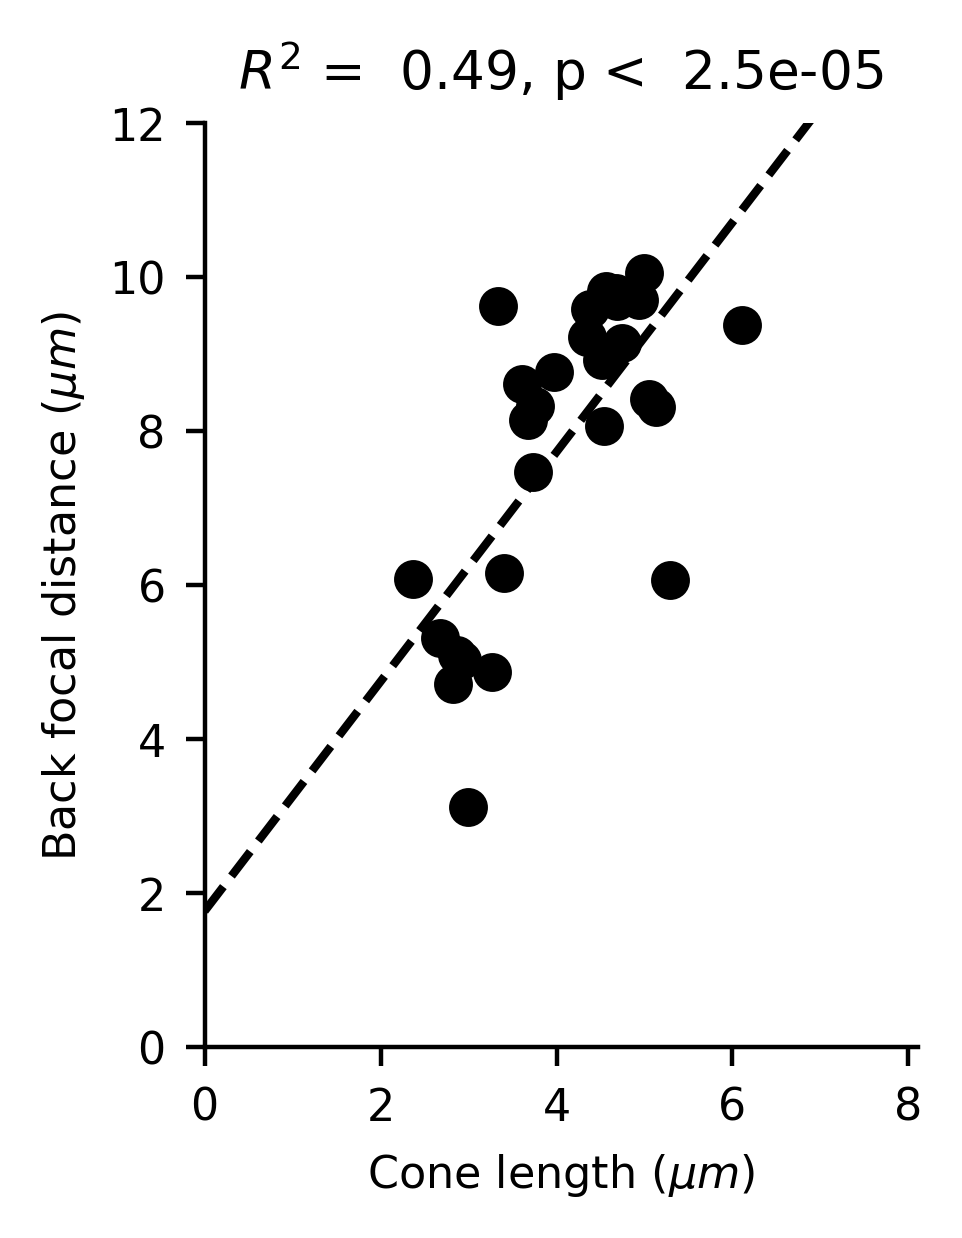

const                         1.763296
cone length (from the tip)    1.490803
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bfd   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     25.69
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           2.54e-05
Time:                        15:17:05   Log-Likelihood:                -50.892
No. Observations:                  29   AIC:                             105.8
Df Residuals:                      27   BIC:                             108.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.7633      1.227      1.437      0.162      -0.755       4.282
cone length (from the tip)     1.4908      0.294      5.068      0.000       0.887       2.094
==============================================================================
Omnibus:                        3.441   Durbin-Watson:                   2.430
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                2.224
Skew:                          -0.661   Prob(JB):                        0.329
Kurtosis:                       3.307   Cond. No.                         20.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
#Y = optics_df['f-image'] + optics_df['e_back'].dropna()  # e_back is neg.
Y = optics_df['bfd'].dropna()
_x = optics_df.loc[Y.index, 'cone length (from the tip)']
X = sm.add_constant(_x)


model = sm.OLS(Y, X)
results = model.fit()
params = results.params
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 3.0])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')
#ax.xlim([0, 8])
#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Cone length ($\mu{m}$)')
ax.set_ylabel("Back focal distance ($\mu{m}$)")

plt.xlim([0, max(_x) + 2])
plt.ylim([0, 12])
#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x) + 2)
ax.plot(xx, params['const'] + params['cone length (from the tip)'] * xx, c='k', ls='--')

plt.show()


fig.savefig(fig_path + '230619_focal_rhabdom-dist_scatter' + '.svg')
fig.savefig(fig_path + '230619_focal_rhabdom-dist_scatter' + '.png')

# SHOW OLS RESULTS
display(params)
display(results.summary())

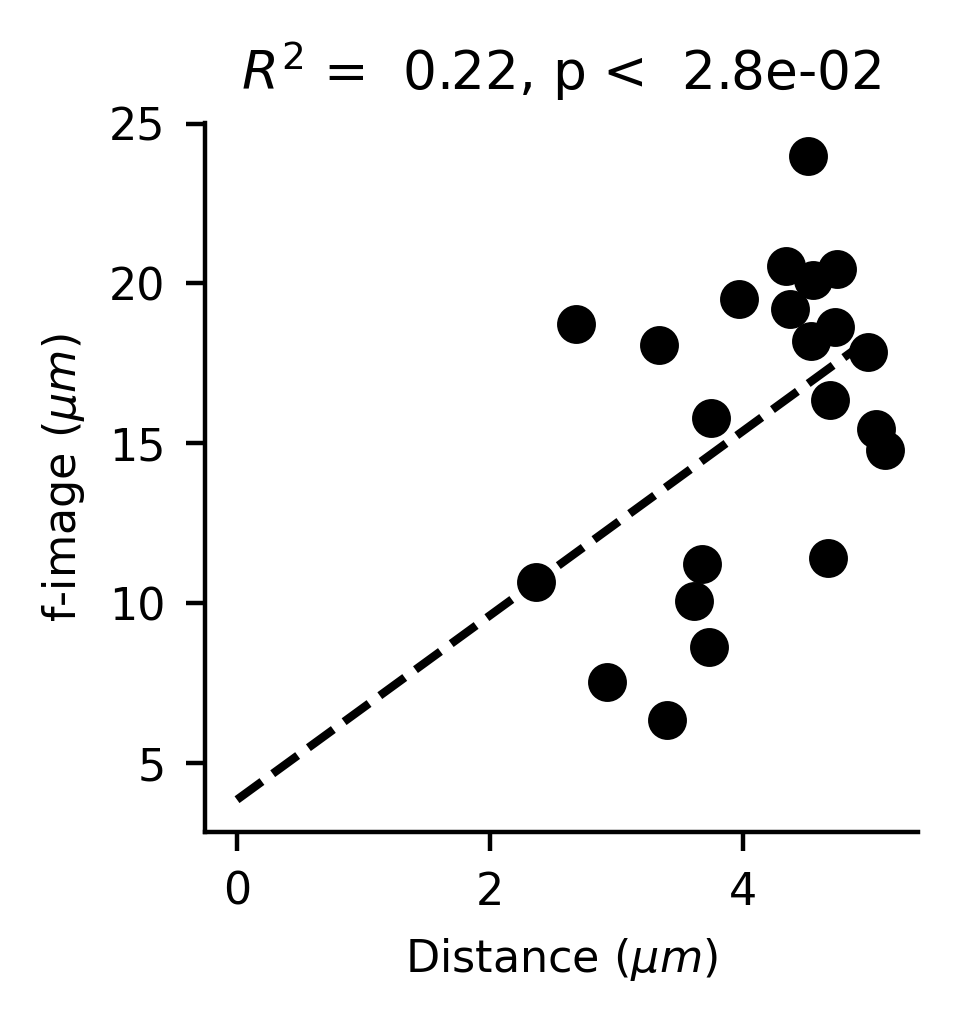

const                         3.852292
cone length (from the tip)    2.881941
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f-image   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     5.618
Date:                Sun, 18 Jun 2023   Prob (F-statistic):             0.0279
Time:                        17:07:10   Log-Likelihood:                -62.770
No. Observations:                  22   AIC:                             129.5
Df Residuals:                      20   BIC:                             131.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          3.8523      5.050      0.763      0.454      -6.682      14.387
cone length (from the tip)     2.8819      1.216      2.370      0.028       0.346       5.418
==============================================================================
Omnibus:                        2.097   Durbin-Watson:                   1.452
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.077
Skew:                          -0.035   Prob(JB):                        0.584
Kurtosis:                       1.918   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
# Y = optics_df['f-image'].dropna()
# _x = optics_df.loc[Y.index, 'cone length (from the tip)']
# X = sm.add_constant(_x)


# model = sm.OLS(Y, X)
# results = model.fit()
# params = results.params
# # ~~~
# fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# # c = []
# # for om in optics_df.index:
# #     if om in dra_om:
# #         c.append('darkviolet')
# #     else:
# #         c.append('darkgreen')

# #ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
# ax.scatter(x=_x, y=Y, c='k', marker='o')
# ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
# ax.set_xlabel('Distance ($\mu{m}$)')
# ax.set_ylabel("f-image ($\mu{m}$)")

# #xx = np.arange(min(_x), max(_x))
# xx = np.arange(0, max(_x))
# ax.plot(xx, params['const'] + params['cone length (from the tip)'] * xx, c='k', ls='--')

# plt.show()

# if save_figs:
#     fig.savefig(fig_path + 'focal_rhabdom-dist_scatter' + '.svg')
#     fig.savefig(fig_path + 'focal_rhabdom-dist_scatter' + '.png')

# # SHOW OLS RESULTS
# display(params)
# display(results.summary())

const                         1.763296
cone length (from the tip)    1.490803
dtype: float64

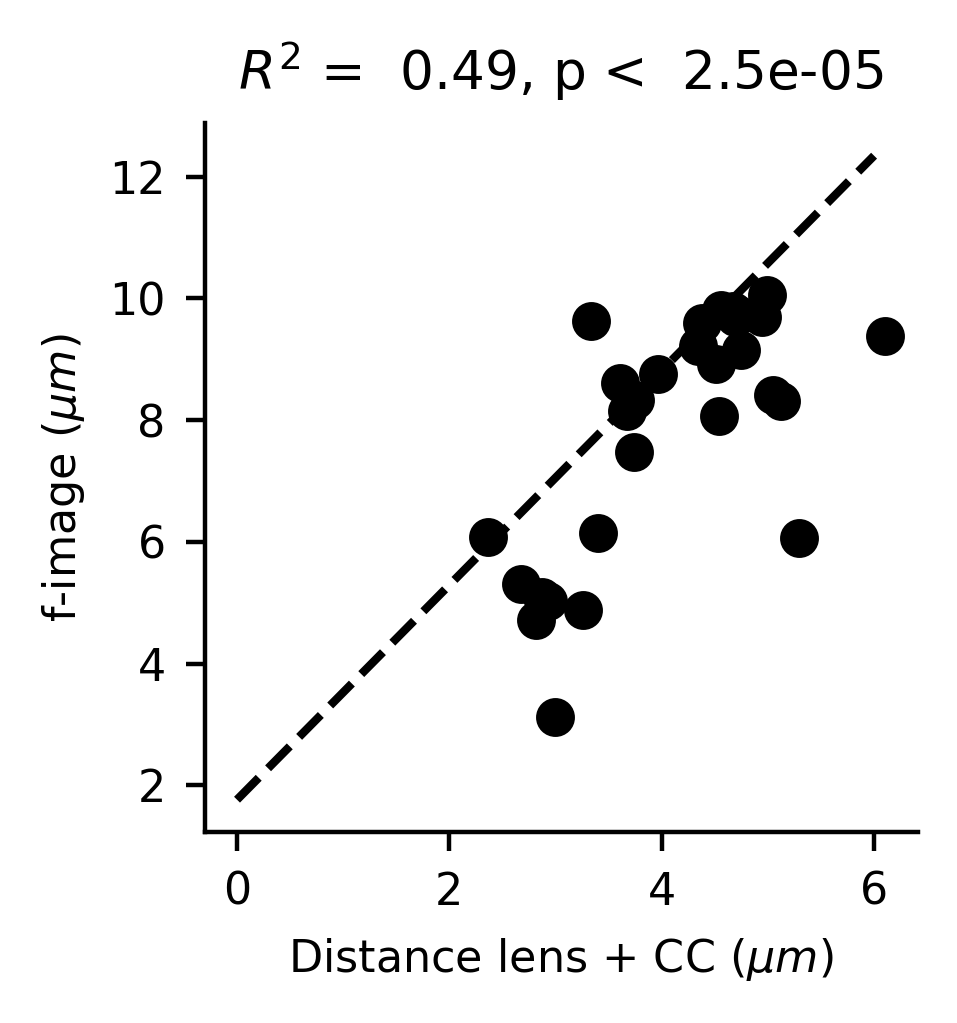

const                         1.763296
cone length (from the tip)    1.490803
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bfd   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     25.69
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           2.54e-05
Time:                        15:04:49   Log-Likelihood:                -50.892
No. Observations:                  29   AIC:                             105.8
Df Residuals:                      27   BIC:                             108.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.7633      1.227      1.437      0.162      -0.755       4.282
cone length (from the tip)     1.4908      0.294      5.068      0.000       0.887       2.094
==============================================================================
Omnibus:                        3.441   Durbin-Watson:                   2.430
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                2.224
Skew:                          -0.661   Prob(JB):                        0.329
Kurtosis:                       3.307   Cond. No.                         20.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# #Y = optics_df['f-image'].dropna()
# Y = optics_df['bfd'].dropna()
# _x = optics_df.loc[Y.index, 'cone length (from the tip)'] #+ optics_df.loc[Y.index, 'lense thickness']
# X = sm.add_constant(_x)


# model = sm.OLS(Y, X)
# results = model.fit()
# params = results.params
# display(params)
# # ~~~
# fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# # c = []
# # for om in optics_df.index:
# #     if om in dra_om:
# #         c.append('darkviolet')
# #     else:
# #         c.append('darkgreen')

# #ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
# ax.scatter(x=_x, y=Y, c='k', marker='o')
# ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
# ax.set_xlabel('Distance lens + CC ($\mu{m}$)')
# ax.set_ylabel("f-image ($\mu{m}$)")

# #xx = np.arange(min(_x), max(_x))
# xx = np.arange(0, max(_x))
# ax.plot(xx, params['const'] + params[0] * xx, c='k', ls='--')

# plt.show()

# if save_figs:
#     fig.savefig(fig_path + 'focal_rhabdom-dist_scatter' + '.svg')
#     fig.savefig(fig_path + 'focal_rhabdom-dist_scatter' + '.png')

# # SHOW OLS RESULTS
# display(params)
# display(results.summary())

# Focal length is also linearly related to the distal diameter of the rhabdom
- $D_{Rh} / f$ approximates the ommatidium's acceptance angle based on the geometry of the lens and rhabdom surface 

const             -0.167748
D rhabdom dist.    3.210976
dtype: float64

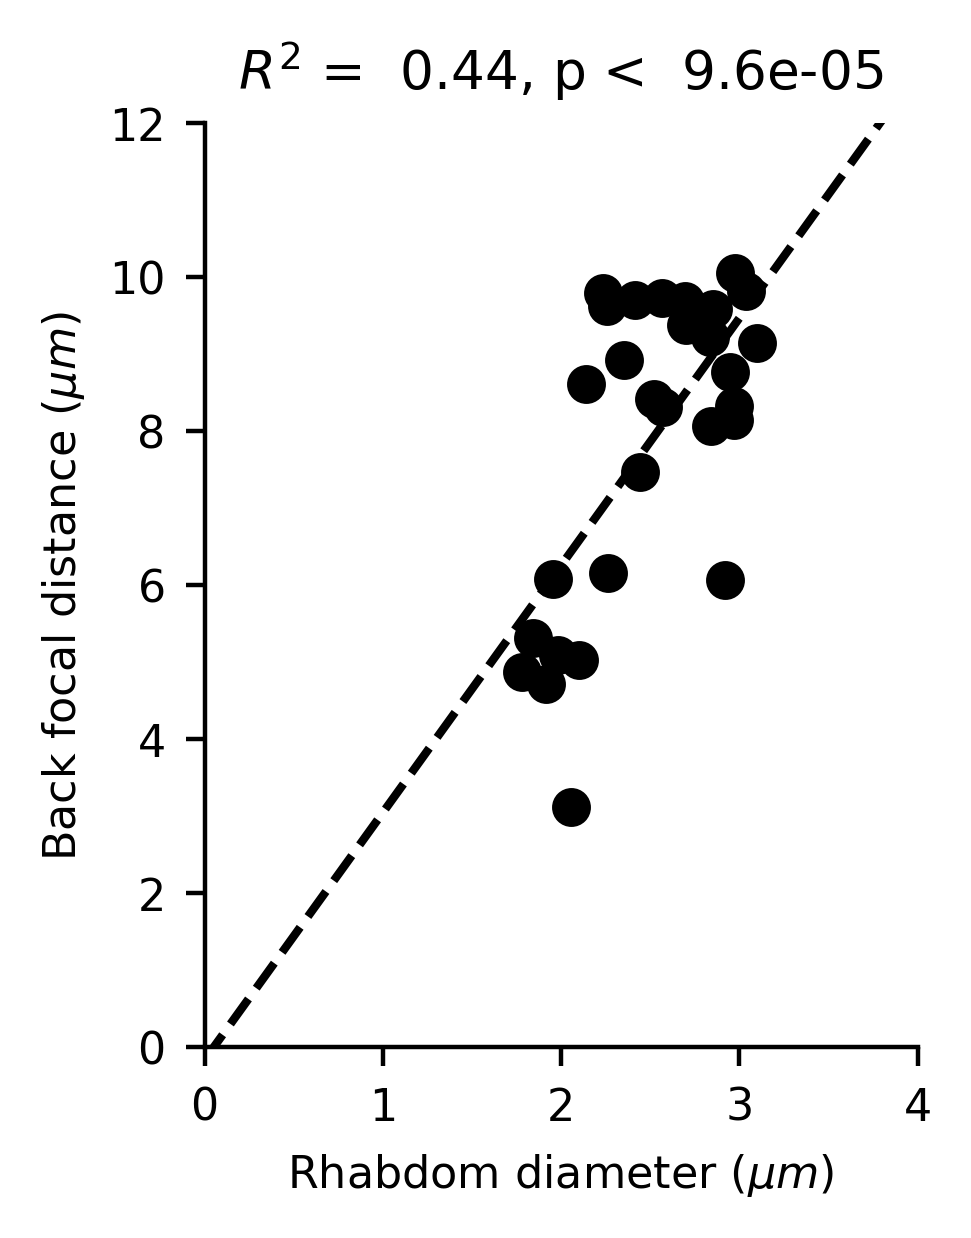

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bfd   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     20.91
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           9.59e-05
Time:                        15:17:25   Log-Likelihood:                -52.268
No. Observations:                  29   AIC:                             108.5
Df Residuals:                      27   BIC:                             111.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1677      1.772     -0.095      0.925      -3.804       3.468
D rhabdom dist.     3.2110      0.702      4.573      0.000       1.770       4.652
==============================================================================
Omnibus:                        0.279   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.157
Skew:                          -0.165   Prob(JB):                        0.924
Kurtosis:                       2.854   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
#Y = optics_df['f'].dropna()
Y = optics_df['bfd'].dropna()
_x = optics_df.loc[Y.index, 'D rhabdom dist.'] 
X = sm.add_constant(_x)

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 3.0])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Rhabdom diameter ($\mu{m}$)')
ax.set_ylabel("Back focal distance ($\mu{m}$)")


#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x) + 1)
ax.plot(xx, params['const'] + params['D rhabdom dist.'] * xx, c='k', ls='--')


plt.xlim([0, 4])
plt.ylim([0, 12])
plt.show()


fig.savefig(fig_path + 'bfd_rhabdom-diam_scatter' + '.svg')
fig.savefig(fig_path + 'bfd_rhabdom-diam_scatter' + '.png')

# SHOW OLS RESULTS
display(results.summary())

const             -0.157943
D rhabdom dist.    3.207420
dtype: float64

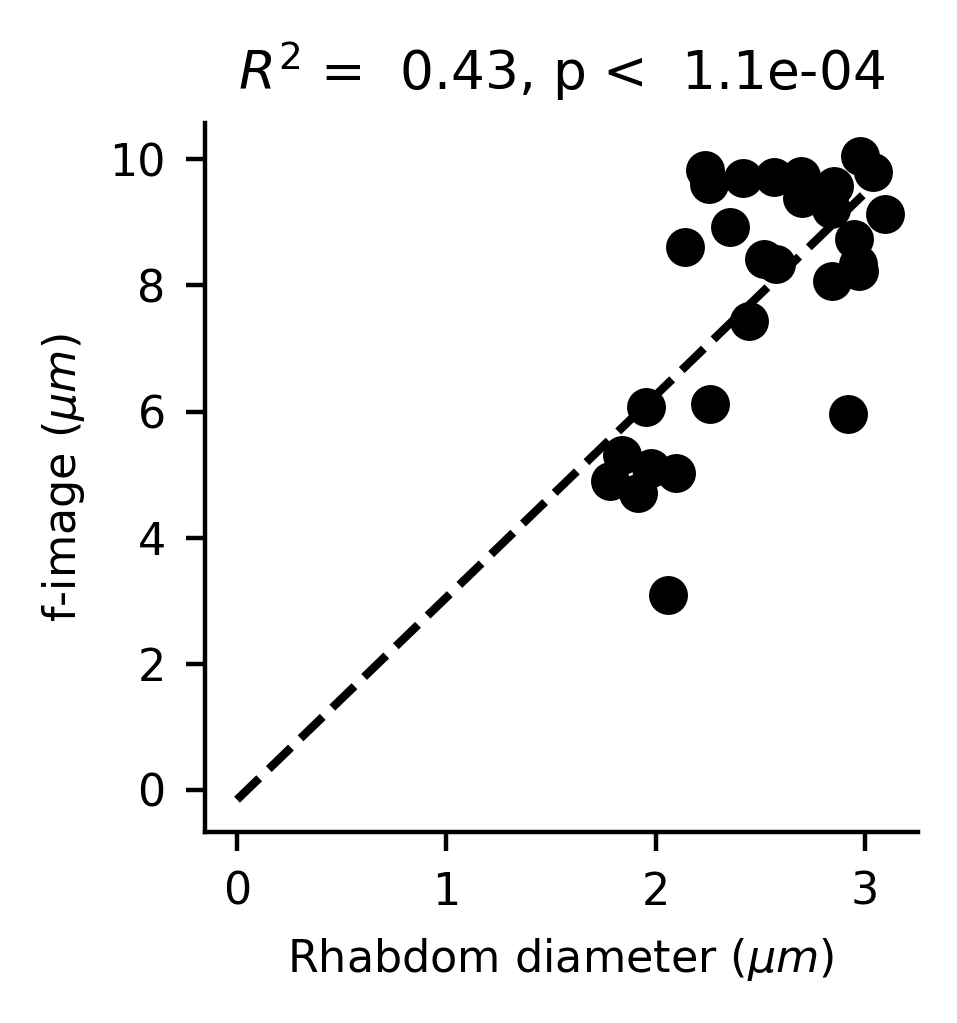

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bfd   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     20.52
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           0.000108
Time:                        14:20:44   Log-Likelihood:                -52.513
No. Observations:                  29   AIC:                             109.0
Df Residuals:                      27   BIC:                             111.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1579      1.787     -0.088      0.930      -3.825       3.509
D rhabdom dist.     3.2074      0.708      4.530      0.000       1.755       4.660
==============================================================================
Omnibus:                        0.409   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.188
Skew:                          -0.193   Prob(JB):                        0.910
Kurtosis:                       2.916   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
Y = optics_df['bfd'].dropna()
_x = optics_df.loc[Y.index, 'D rhabdom dist.'] 
X = sm.add_constant(_x)

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Rhabdom diameter ($\mu{m}$)')
ax.set_ylabel("f-image ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params['const'] + params['D rhabdom dist.'] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig(fig_path + 'focal_rhabdom-diam_scatter' + '.svg')
    fig.savefig(fig_path + 'focal_rhabdom-diam_scatter' + '.png')

# SHOW OLS RESULTS
display(results.summary())

[0.20117106 0.15390923 0.16560149 0.1459857  0.15178908 0.13240213
 0.15642088 0.13738714 0.15115826 0.23981192 0.20777808 0.14108222
 0.13278374 0.13987742 0.13031451 0.14882664 0.24965857 0.14533123
 0.12845308 0.12700191 0.12984467 0.12929242]
[[ 1.         26.39389743]
 [ 1.         26.43036892]
 [ 1.         23.45782242]
 [ 1.         24.9857009 ]
 [ 1.         26.11435557]
 [ 1.         17.47975453]
 [ 1.         25.66492322]
 [ 1.         22.6855393 ]
 [ 1.         22.70503424]
 [ 1.         25.71883002]
 [ 1.         23.65713771]
 [ 1.         19.35142233]
 [ 1.         22.03095706]
 [ 1.         25.08914014]
 [ 1.         19.53113259]
 [ 1.         21.85961842]
 [ 1.         30.43021291]
 [ 1.         18.1363372 ]
 [ 1.         16.75170118]
 [ 1.         21.90155696]
 [ 1.         22.86759272]
 [ 1.         20.31089042]]


array([-0.00377076,  0.00700787])

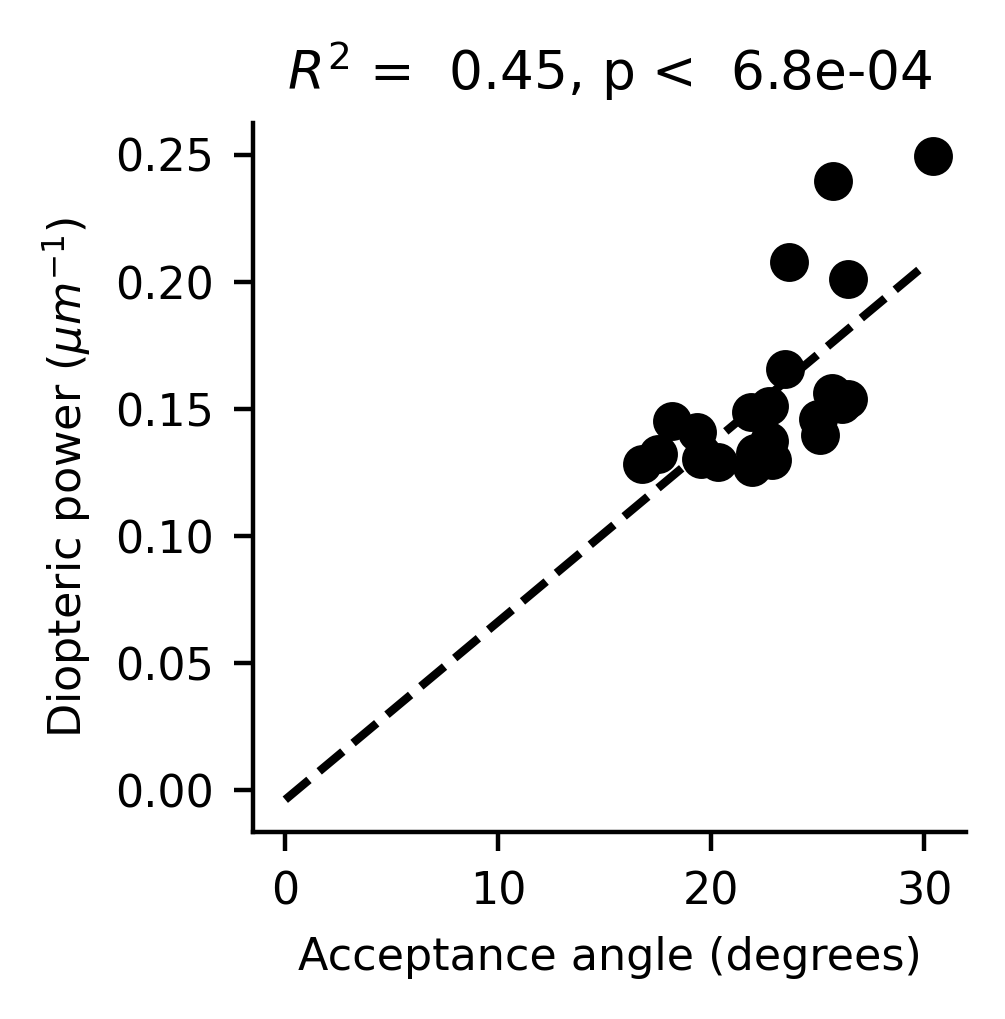

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     16.12
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           0.000679
Time:                        17:13:46   Log-Likelihood:                 49.226
No. Observations:                  22   AIC:                            -94.45
Df Residuals:                      20   BIC:                            -92.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.040     -0.093      0.927      -0.088       0.080
x1             0.0070      0.002      4.015      0.001       0.003       0.011
==============================================================================
Omnibus:                        3.089   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.213   Jarque-Bera (JB):                2.318
Skew:                           0.788   Prob(JB):                        0.314
Kurtosis:                       2.794   Cond. No.                         162.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
Y = 1.0/np.asarray(optics_df.loc[lens_centers_out.index, 'f'])
_x = optics_df.loc[lens_centers_out.index, 'rho'] 
X = np.asarray(sm.add_constant(_x))

print(np.asarray(Y))
print(X)

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_ylabel('Diopteric power ($\mu{m}^{-1}$)')
ax.set_xlabel("Acceptance angle (degrees)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig(fig_path + 'Drh_f_rhabdom_scatter_fullscale.svg')
    fig.savefig(fig_path + 'Drh_f_rhabdom_scatter_fullscale.png')

# SHOW OLS RESULTS
display(results.summary())

array([-0.00377076,  0.00700787])

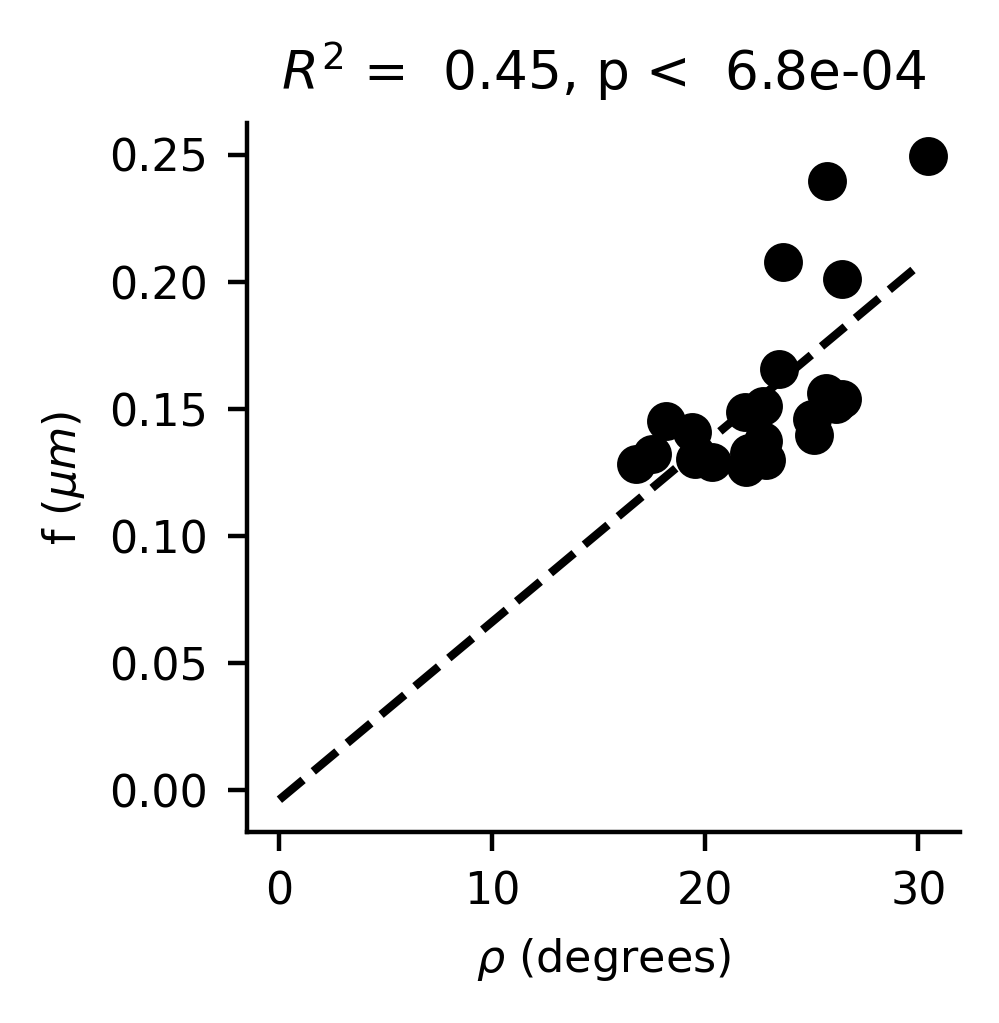

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     16.12
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           0.000679
Time:                        17:13:47   Log-Likelihood:                 49.226
No. Observations:                  22   AIC:                            -94.45
Df Residuals:                      20   BIC:                            -92.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.040     -0.093      0.927      -0.088       0.080
x1             0.0070      0.002      4.015      0.001       0.003       0.011
==============================================================================
Omnibus:                        3.089   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.213   Jarque-Bera (JB):                2.318
Skew:                           0.788   Prob(JB):                        0.314
Kurtosis:                       2.794   Cond. No.                         162.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
Y = 1.0/np.asarray(optics_df.loc[lens_centers_out.index, 'f'])
_x = optics_df.loc[lens_centers_out.index, 'rho'] 
X = np.asarray(sm.add_constant(_x))

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel(r'$\rho$ (degrees)')
ax.set_ylabel("f ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig(fig_path + 'Drh_f_rhabdom_scatter_fullscale.svg')
    fig.savefig(fig_path + 'Drh_f_rhabdom_scatter_fullcale.png')

# SHOW OLS RESULTS
display(results.summary())

/Users/nchua/src/cx-analysis/cx_analysis/vis/fig_tools.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clist = np.array([min_colour, max_colour])


lense diameter (stack)
lense thickness
cone length (from the tip)
cone width (under the lense tip)
D rhabdom dist.
D rhabdom prox.
Mean Microv. Ang. Turn
rhabdom_len
radius_in
radius_out
lens_thickness
f
f-image
P
bfd
e_front
e_back
rho_l
rho_rh
rho
S


IndexError: index 20 is out of bounds for axis 0 with size 20

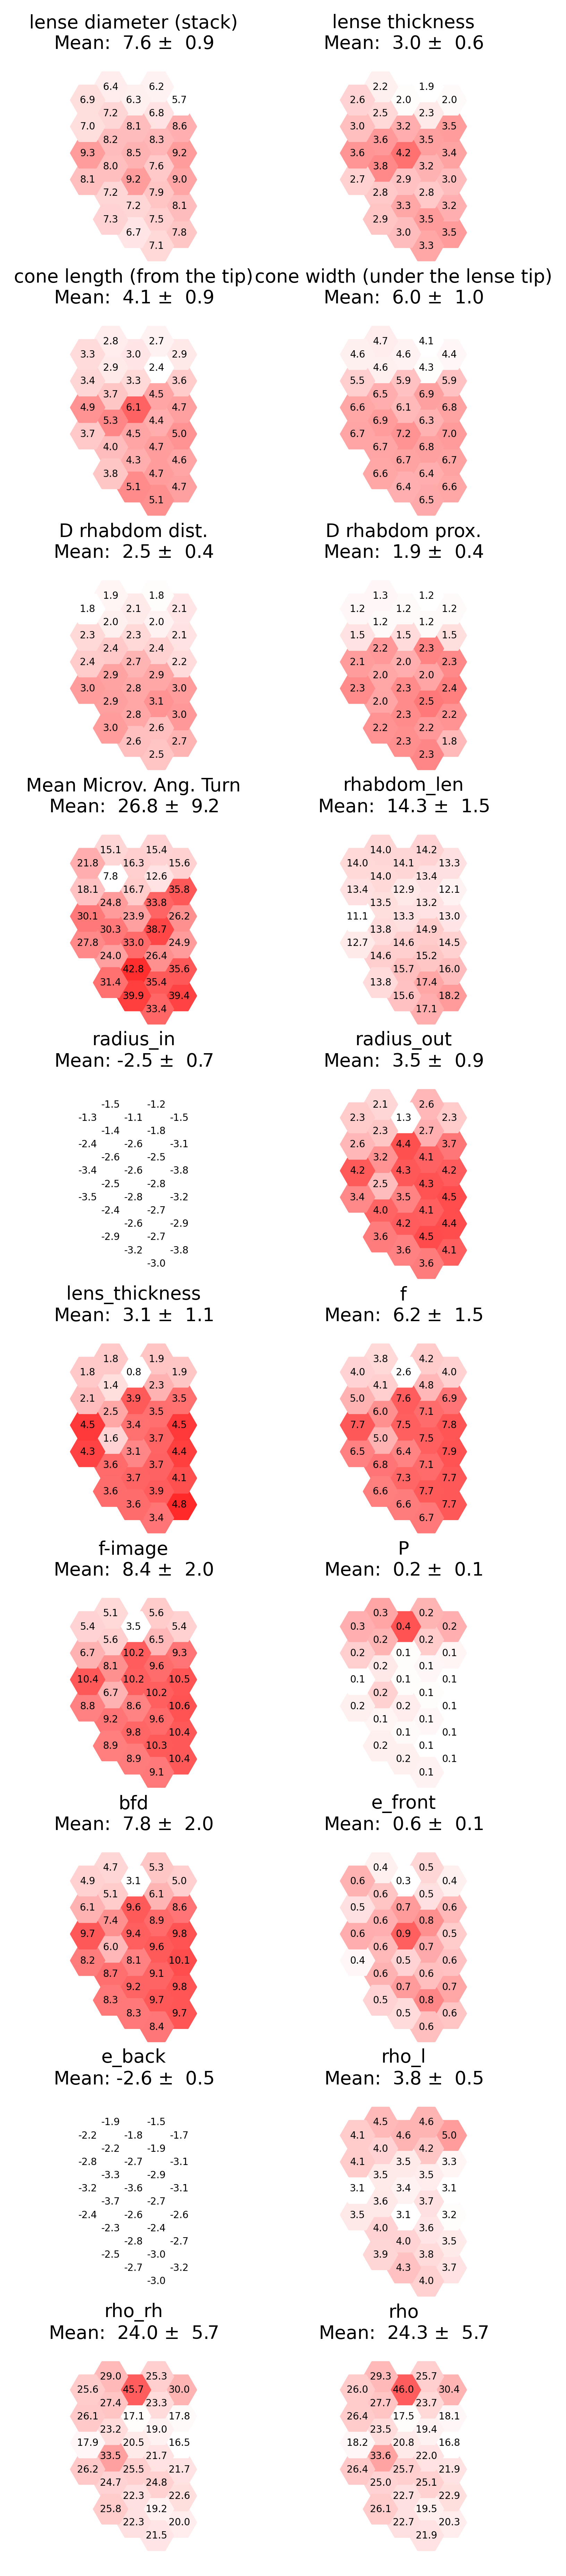

In [114]:
fig, ax = plt.subplots(10, 2, figsize=(4.6, 9.0*2.6))
axes = ax.flatten()
lincm = linear_cmap(n_vals=100, max_colour='r')

param_labels = ['D, facet diameter ($\mu{m}$)', 'l, lens thickness ($\mu{m}$)', '$r_1$, outer curvature ($\mu{m}$)',
               '$r_2$, inner curvature ($\mu{m}$)', 'Cone length ($\mu{m}$)', 'Cone width ($\mu{m}$)', '$D_{Rh}$, Dist. rhab diameter ($\mu{m}$)', 
               'Prox. rhab diameter ($\mu{m}$)', 'Rhabdom length ($\mu{m}$)', 'f, object focal length ($\mu{m}$)', "f', image focal length ($\mu{m}$)",
               'Dioptric power', 'F-number', 'Acceptance angle Rh (degrees)', 'Acceptance angle L, (degrees)', 'Acceptance angle, (degrees)', 
               'S, Optical sensitivity ($\mu{m}^2 sr$)']

param_labels = ['D, facet diameter ($\mu{m}$)', 'l, lens thickness ($\mu{m}$)', 'Cone length ($\mu{m}$)', 'Cone width ($\mu{m}$)', '$D_{Rh}$, Dist. rhab diameter ($\mu{m}$)', 
               'Prox. rhab diameter ($\mu{m}$)', 'Rhabdom length ($\mu{m}$)', 'f, object focal length ($\mu{m}$)', "f', image focal length ($\mu{m}$)",
               'Dioptric power', 'F-number', 'Acceptance angle Rh (degrees)', 'Acceptance angle L, (degrees)', 'Acceptance angle, (degrees)', 
               'S, Optical sensitivity ($\mu{m}^2 sr$)']


i = 0
for param, vals in optics_df.iteritems():
    if param == 'region':
        continue
    print(param)
    max_val = vals.max()
    min_val = vals.min()
    
    node_data = {om: {'label': np.round(v, decimals=1),
                      'colour': lincm((v-min_val)/max_val)} for om, v in vals.items()}
    hexplot(node_data, ax=axes[i])
    axes[i].set_title(f"{param}\n" + 
                      f"Mean: {vals.mean(): .1f} $\pm$ {vals.std(ddof=0): .1f}")
    i += 1
axes[-1].set_visible(False)
plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/optic_params_hex.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/optic_params_hex.png')